# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You are supposed to train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be automated testing on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [26]:
# from google.colab import drive
# drive.mount('/content/drive')
#Test edit

In [1]:
from sklearn.model_selection import train_test_split

import tensorflow

import keras 
from keras.datasets import mnist 
from keras.models import Model, Sequential 
from keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
                          BatchNormalization, GlobalAveragePooling2D,
                         Input)
from keras import backend as K 
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
import os, cv2

In [2]:
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Device mapping: no known devices.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12118531667744246361
xla_global_id: -1
]
Num GPUs Available:  0


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [2]:
# from google.colab.patches import cv2_imshow

#file_path = './drive/MyDrive/ML2/train_val/'
# file_path = './train_val'
file_path='D:\\train_val'

# # Get the list of images from the train_val directory
# images_list = os.listdir(file_path)

# # Display 20 images
# for i in range(20):
#     # Get the current image name
#     img_name = images_list[i]
#     # Split the image name using the underscores as a delimiter
#     image_numbers = img_name.split('_')
#     # Age is the first number in the file name, sex is the second number (0 == male, 1 == female)
#     age = int(image_numbers[0])
#     sex = int(image_numbers[1])
#     # Read in image with cv2
#     img = file_path+img_name
#     image = cv2.imread(img)
#     # Print the image above the information
#     cv2_imshow(image)
#     # Print the person information below the image
#     print('Age =', age, '\b; Sex =', ('Male' if sex==0 else 'Female'))
#     print()

In [3]:
#from google.colab.patches import cv2_imshow
#visualise image which is not a face and is incorporated in dataset
imNotFace=cv2.imread(file_path+'1_1_0_20170109194452834.jpg.chip.jpg')
# cv2_imshow(imNotFace)
imNotFace2=cv2.imread(file_path+'1_1_4_20170109194502921.jpg.chip.jpg')
# cv2_imshow(imNotFace2)

NameError: name 'cv2_imshow' is not defined

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [4]:
# Get the list of images from the train_val directory
images_list = os.listdir(file_path)
random.shuffle(images_list)

#create a df
dataList = []
for i in range(0,len(images_list)):
        ImageName = images_list[i]
        rowData = []
        data = ImageName.split('_')
        date = data[3].split('.')[0]
        imNameJpg = ImageName.split('.')[0]+".jpg"
        rowData.extend([ImageName,int(data[0]),int(data[1]),int(data[2]),int(date),imNameJpg])
        dataList.append(rowData)
        
df = pd.DataFrame(dataList,columns=['ImageFileName','age','gender','race','data','JpgImageFileName'])

In [5]:
#removes rows from df which correspond to images which are not faces
df = df[df.ImageFileName !='1_1_0_20170109194452834.jpg.chip.jpg']
df = df[df.ImageFileName !='1_1_4_20170109194502921.jpg.chip.jpg']
#check only 2 rows have been removed as shape
df.shape

(4998, 6)

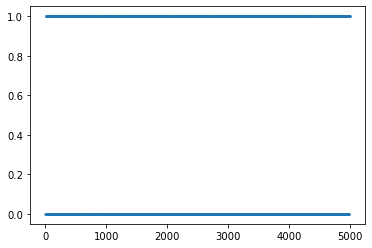

In [6]:
# Sanity check that gender is randomly distributed in the dataframe
plt.plot(np.arange(0, len(df), 1), df['gender'], 'o', markersize=1)
plt.show()

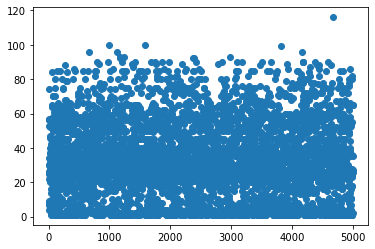

In [7]:
# Sanity check that the ages are randomly distributed in the dataframe
plt.plot(np.arange(0, len(df), 1), df['age'], 'o')
plt.show()

In [8]:
# Split the dataset into 4500 training and validation, 500 for validation during hyperparameter tuning
train_df = df[:4500]
val_df = df[4500:]

# hyper_val_df = df[4500:]

# # train data will be generated using the tensorflow.keras.preprocessing.image.ImageDataGenerator function

# # initialise list that will hold the validation image data for hyperparameter tuning
# val_image_list = []
# hyper_val_image_list = []

# # training validation data
# for i, val_image in val_df.iterrows():
#     image = cv2.imread(file_path + val_image[0])
#     val_image_list.append(image)
# val_images = np.array(val_image_list, dtype=float)

# # hyperparameter validation data
# for i, val_image in hyper_val_df.iterrows():
#     image = cv2.imread(file_path + val_image[0])
#     hyper_val_image_list.append(image)
# hyper_val_images = np.array(hyper_val_image_list, dtype=float)

# # save the y data to numpy arrays
# y_sex_train = train_df['gender']
# y_age_train = train_df['age']
# y_sex_val = val_df['gender']
# y_age_val = val_df['age']

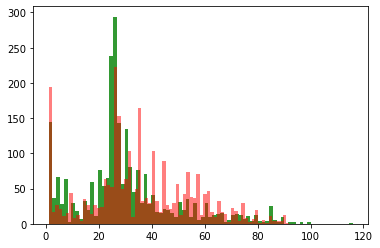

In [9]:
plt.hist(df['age'][df['gender']==1],bins=80,alpha=0.8,color='green')
plt.hist(df['age'][df['gender']==0],bins=70,color='red',alpha=0.5)
plt.show()

(array([194.,  17.,  27.,  15.,   6.,  11.,  16.,  44.,   8.,  12.,   4.,
         18.,  17.,  27.,  33.,   7.,  22.,  24.,  36.,  27.,  55., 275.,
         60.,  93.,  50.,  63.,  35.,  68.,  10., 153.,  61.,  32.,  37.,
         29.,  82.,  22.,  49.,  14.,  75.,  27.,  21.,  16.,  14.,  69.,
         42.,  26.,  47.,  38.,  37.,  18.,  65.,  42.,  20.,  26.,  17.,
         10.,  33.,  11.,  20.,   3.,  20.,   2.,  18.,   4.,   5.,  33.,
          3.,   7.,   1.,  18.,   1.,   5.,   1.,  11.,   4.,   1.,   3.,
          4.,  12.,   1.]),
 array([ 1.    ,  2.1375,  3.275 ,  4.4125,  5.55  ,  6.6875,  7.825 ,
         8.9625, 10.1   , 11.2375, 12.375 , 13.5125, 14.65  , 15.7875,
        16.925 , 18.0625, 19.2   , 20.3375, 21.475 , 22.6125, 23.75  ,
        24.8875, 26.025 , 27.1625, 28.3   , 29.4375, 30.575 , 31.7125,
        32.85  , 33.9875, 35.125 , 36.2625, 37.4   , 38.5375, 39.675 ,
        40.8125, 41.95  , 43.0875, 44.225 , 45.3625, 46.5   , 47.6375,
        48.775 , 49.9125, 51

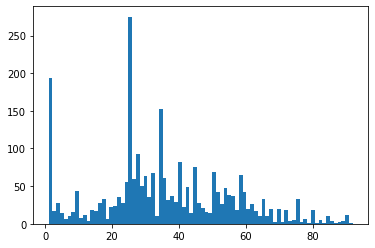

In [ ]:
plt.hist(df['age'][df['gender']==0],bins=80)
plt.show()

(array([7.39e+02, 5.41e+02, 1.93e+03, 6.68e+02, 5.35e+02, 2.93e+02,
        1.89e+02, 9.30e+01, 9.00e+00, 1.00e+00]),
 array([  1. ,  12.5,  24. ,  35.5,  47. ,  58.5,  70. ,  81.5,  93. ,
        104.5, 116. ]),
 <BarContainer object of 10 artists>)

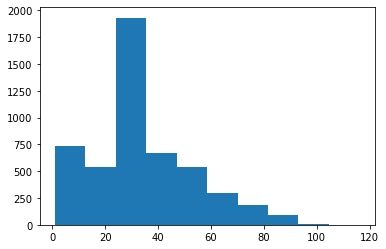

In [11]:
plt.hist(df['age'],bins=10)
plt.show()

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [12]:
prePro = ImageDataGenerator(
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          rotation_range=10,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          validation_split=1/9, # 500 images for validation
                          rescale=1/255.0)

preHyperPro = ImageDataGenerator(rescale=1/255.0)

train_datagen = prePro.flow_from_dataframe(dataframe=train_df, directory=file_path,
                                         subset='training',batch_size=32,
                                         x_col="ImageFileName",
                                         y_col=['gender','age'],
                                         target_size=(128, 128),
                                         class_mode='multi_output', color_mode='rgb')

val_datagen = prePro.flow_from_dataframe(dataframe=train_df, directory=file_path,
                                         subset='validation',batch_size=32,
                                         x_col="ImageFileName",
                                         y_col=['gender','age'],
                                         target_size=(128, 128),
                                         class_mode='multi_output',color_mode='rgb')

hyper_val_datagen = preHyperPro.flow_from_dataframe(dataframe=val_df, directory=file_path,
                                         batch_size=32,
                                         x_col="ImageFileName",
                                         y_col=['gender','age'],
                                         target_size=(128, 128),
                                         class_mode='multi_output',color_mode='rgb',
                                         shuffle=False)

Found 4000 validated image filenames.
Found 500 validated image filenames.
Found 498 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [14]:
class CNN:
    
    def __init__(self, num_conv_layers, num_dense_layers, num_dense_units, split=3, name=None):
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.num_dense_units = num_dense_units
        self.split = split
        
        self.name = name
        
        self.inputs = []
        self.inputs.append(Input(shape=(128,128,3)))
        
        # construct the model 
        inputs1, inputs2 = self._get_conv_layers_both()
        inputs1 = self._get_dense_layers(inputs1)
        inputs2 = self._get_dense_layers(inputs2)
        self._get_output_layers(inputs1, inputs2)
        
        self.model = Model(inputs=self.inputs[0], outputs=[self.output_layers[0], self.output_layers[1]])
        self.model.compile(loss={'gender':'binary_crossentropy', 'age':'mse'}, optimizer=Adam(learning_rate=1e-3),
                           metrics={'gender':'accuracy', 'age':'mae'})
        
    def find_filters(self, layer):
        if layer == 0:
            num_filters = 64
        elif layer == 1:
            num_filters = 128
        elif layer == 2:
            num_filters = 256
        else:
            num_filters = 512
            
        return num_filters
        
    def _get_conv_layers_both(self):
        for layer in range(self.split):
            
            num_filters = self.find_filters(layer)
            self.inputs = self._get_conv_layers(self.inputs, num_filters)
            
        inputs1 = [self.inputs[-1]]
        inputs2 = [self.inputs[-1]]
        
        for layer in range(self.split, self.num_conv_layers):
                
            inputs1 = self._get_conv_layers(inputs1, num_filters)
            inputs2 = self._get_conv_layers(inputs2, num_filters)
            
        return inputs1, inputs2
               
    def _get_conv_layers(self, inputs, num_filters):
        for i in range(2):
            conv_layer = Conv2D(num_filters, (3, 3), activation='relu', padding='same', strides=1)(inputs[-1])
            inputs.append(conv_layer)
            batch_norm = BatchNormalization()(inputs[-1])
            inputs.append(batch_norm)
        pool_layer = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(inputs[-1])
        inputs.append(pool_layer)
            
        return inputs
    
    def _get_dense_layers(self, inputs):
        flat = Flatten()(inputs[-1])
        inputs.append(flat)
        for layer in range(self.num_dense_layers):
            dense_layer = Dense(units=self.num_dense_units, activation='relu',
                                kernel_regularizer=tensorflow.keras.regularizers.l2(1e-5), 
                                bias_regularizer=tensorflow.keras.regularizers.l2(1e-5))(inputs[-1])
            inputs.append(dense_layer)
            batch_norm = BatchNormalization()(inputs[-1])
            inputs.append(batch_norm)
            dropout = Dropout(rate=0.2)(inputs[-1])
            inputs.append(dropout)
            
        return inputs
           
    def _get_output_layers(self, inputs1, inputs2):
        self.output_layers = []
        self.output_layers.append(Dense(1, activation='sigmoid', name='gender')(inputs1[-1]))
        self.output_layers.append(Dense(1, activation='linear', name='age')(inputs2[-1]))
        
    def train(self, train_datagen, val_datagen, epochs=1000):
        early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, restore_best_weights=True)
        self.history = self.model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, 
                       callbacks=[early_stopping_callback], verbose=1)
    
    def cnn_evaluate(self, test_datagen, y_test, metric_function):
        predictions = self.model.predict(test_datagen)
        return metric_function(y_test, predictions)
     
        
def combined_metric(y_true, y_predict):
    """y_true, y_predict shapes = (n_validation_points, 2)
    For this dataset, the missclassification rate (as a percentage) and RMSE happen to be on approximately the same scale
    i.e. their values should be between roughly 0 and 100, therefore the metric used here is
    the average of the two."""
    # get gender vectors
    gender_true = y_true[:,0]
    gender_predictions = np.squeeze(y_predict[0])
    # get age vectors
    age_true = y_true[:,1]
    age_predictions = np.squeeze(y_predict[1])
    # compute metrics for gender classification
    print(tensorflow.metrics.binary_accuracy(gender_true, gender_predictions))
    accuracy = float(tensorflow.metrics.binary_accuracy(gender_true, gender_predictions))
    error_sex = (1 - accuracy) * 100
    print(f'Accuracy: {accuracy}')
    print(f'Error: {error_sex}')
    # compute metrics for age regression
    mae_age = np.mean(np.absolute(age_true - age_predictions))
    mse_age = np.mean(tensorflow.square(age_true - age_predictions))
    rmse_age = float(tensorflow.sqrt(mse_age))
    print(f'MAE: {mae_age}')
    print(f'MSE: {mse_age}')
    print(f'RMSE: {rmse_age}')
    # compute our lovely custom metric
    custom_met = (error_sex + rmse_age) / 2
    print(f'Custom metric: {custom_met}')
    return {'Accuracy': accuracy, 
            'Error_sex': error_sex, 
            'MSE': mse_age, 
            'RMSE': rmse_age,
            'Custom metric': custom_met
           }

def grid_search(models, train_datagen, val_datagen, hyper_val_datagen, y_hyper_val, metric_function):
    results = []
    for model in models:
        model.train(train_datagen, val_datagen)
        score = model.cnn_evaluate(hyper_val_datagen, y_hyper_val, metric_function)
        results.append((model.name, score))
    return results

In [15]:
# cnn_1 = CNN(3, 1, 100, name='CNN 1')
# cnn_2 = CNN(3, 1, 300, name='CNN 2')
# cnn_3 = CNN(3, 3, 100, name='CNN 3')
# cnn_4 = CNN(3, 3, 300, name='CNN 4')
# cnn_5 = CNN(5, 1, 100, name='CNN 5')
# cnn_6 = CNN(5, 1, 300, name='CNN 6')
# models = [cnn_1, cnn_2, cnn_3, cnn_4, cnn_5, cnn_6]

cnn_19 = CNN(5, 2, 100, name='CNN 19')
cnn_20 = CNN(5, 2, 300, name='CNN 20')
cnn_21 = CNN(5, 2, 200, split=4, name='CNN 21')
cnn_22 = CNN(5, 4, 200, name='CNN 22')
cnn_23 = CNN(3, 2, 200, split=1, name='CNN 23')
cnn_24 = CNN(3, 4, 100, split=1, name='CNN 24')
models = [cnn_19, cnn_20, cnn_21, cnn_22, cnn_23, cnn_24]

# results = grid_search(models, train_datagen, val_datagen, hyper_val_datagen, val_df[['gender','age']].to_numpy(), combined_metric)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 64) 256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 36928       batch_normalization_19[0][0]     
____________________________________________________________________________________________

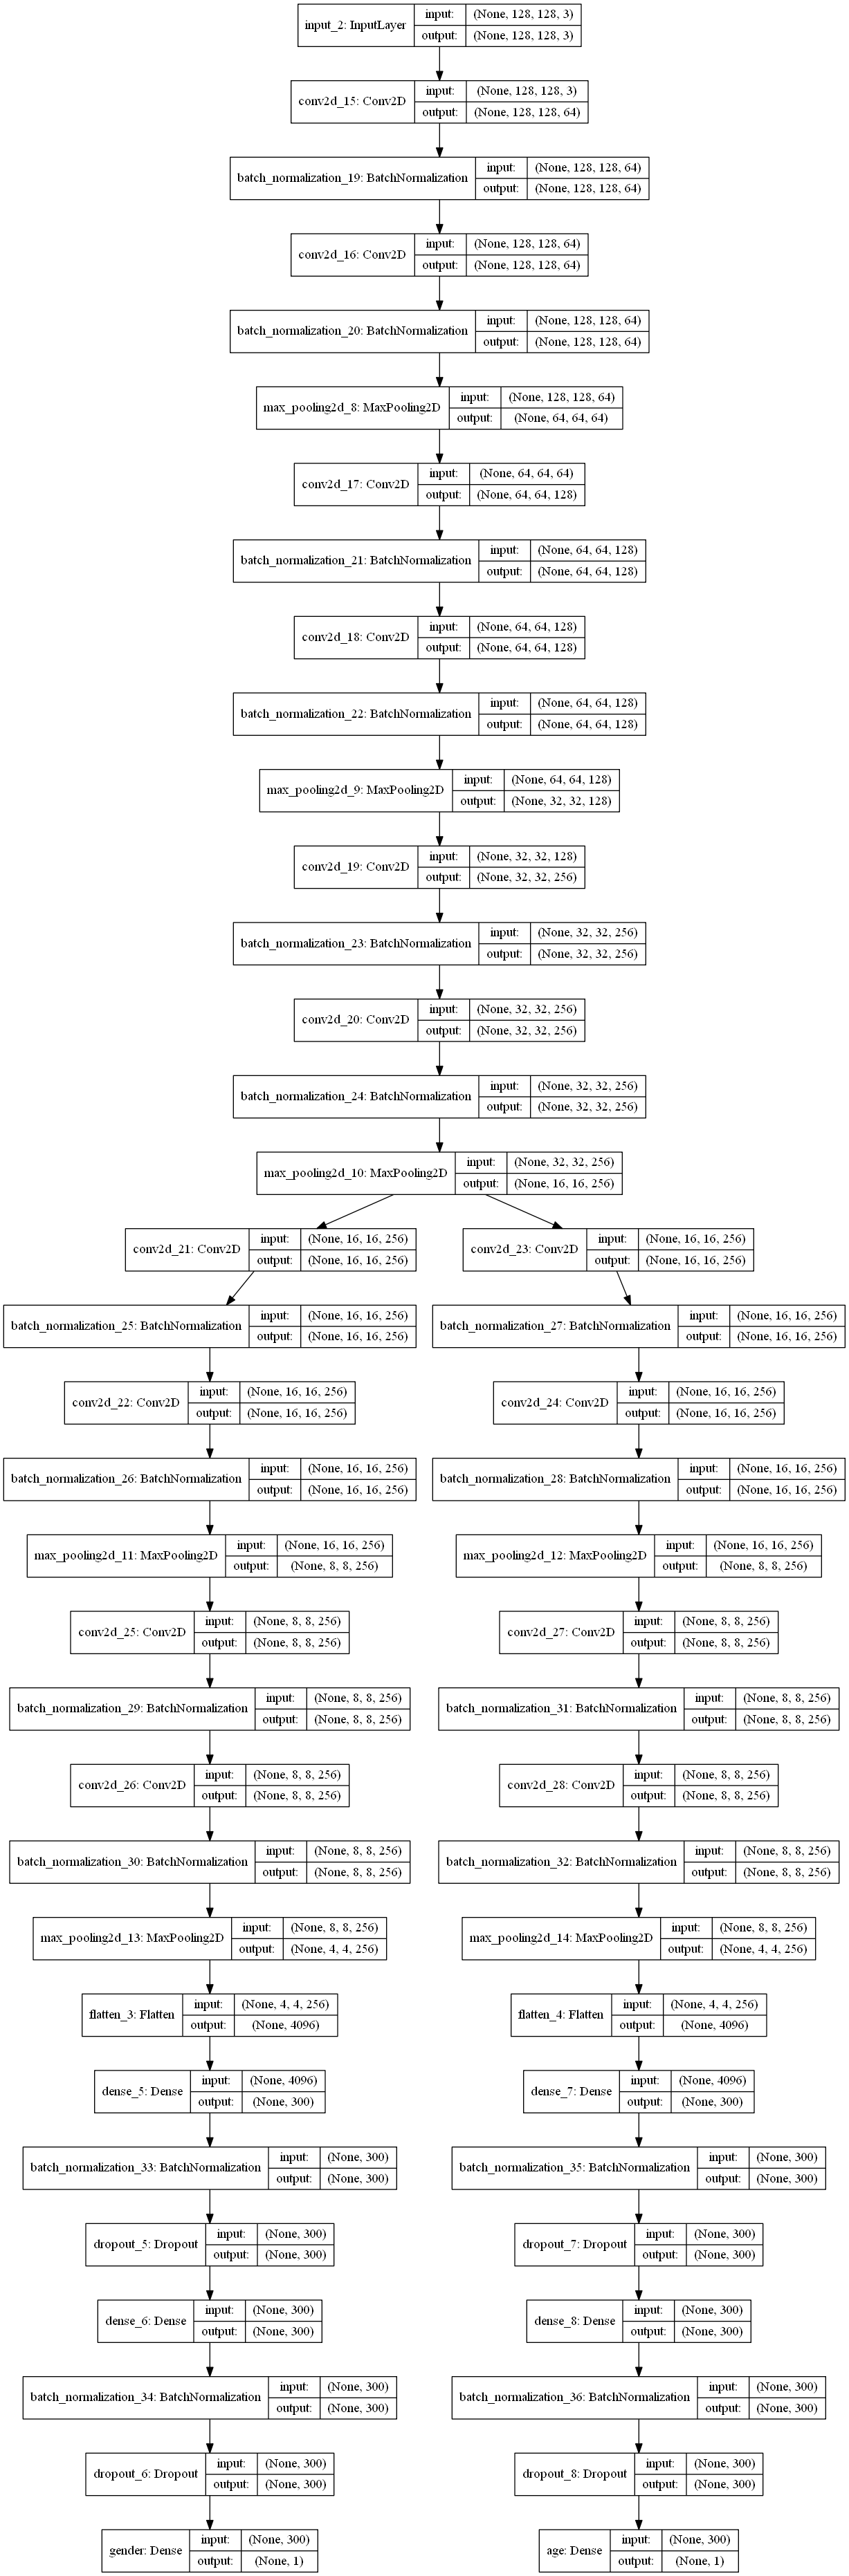

In [16]:
modelA = cnn_20
modelA.model.summary()
from keras.utils import plot_model
plot_model(modelA.model, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save_model(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by `modelA.load_model(model_folder+"age_gender_A.h5")`. 


In [13]:
pre_pro = ImageDataGenerator(
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          rotation_range=10,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          validation_split=0.2, # 1000 images for validation
                          rescale=1/255.0)

train_datagen = pre_pro.flow_from_dataframe(dataframe=df, directory=file_path,
                                         subset='training',batch_size=32,
                                         x_col="ImageFileName",
                                         y_col=['gender','age'],
                                         target_size=(128, 128),
                                         class_mode='multi_output', color_mode='rgb')

val_datagen = pre_pro.flow_from_dataframe(dataframe=df, directory=file_path,
                                         subset='validation',batch_size=32,
                                         x_col="ImageFileName",
                                         y_col=['gender','age'],
                                         target_size=(128, 128),
                                         class_mode='multi_output',color_mode='rgb')

Found 3999 validated image filenames.
Found 999 validated image filenames.


In [14]:
# your_model_folder = '.\\'
# modelA = CNN(5, 2, 300)
# modelA.train(train_datagen, val_datagen)
# modelA.model.save(your_model_folder+"age_gender_A.h5")

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


Text(0.5, 0, 'epoch')

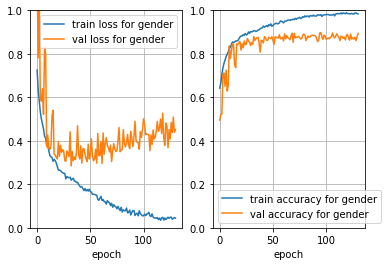

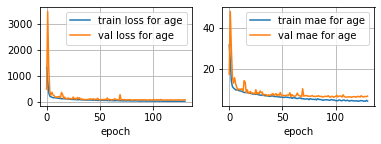

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(modelA.history.history['gender_loss'], label='train loss for gender')
plt.plot(modelA.history.history['val_gender_loss'], label='val loss for gender')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(modelA.history.history['gender_accuracy'], label='train accuracy for gender')
plt.plot(modelA.history.history['val_gender_accuracy'], label='val accuracy for gender')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig = plt.figure()
fig.add_subplot(2,2,1)
plt.plot(modelA.history.history['age_loss'], label='train loss for age')
plt.plot(modelA.history.history['val_age_loss'], label='val loss for age')
plt.legend()
plt.grid(True)
# plt.ylim([0,10])
plt.xlabel('epoch')

fig.add_subplot(2,2,2)
plt.plot(modelA.history.history['age_mae'], label='train mae for age')
plt.plot(modelA.history.history['val_age_mae'], label='val mae for age')
plt.legend()
plt.grid(True)
# plt.ylim([0,1])
plt.xlabel('epoch')

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [33]:
from tensorflow.keras.applications import VGG16

cove_base=VGG16(weights='imagenet',include_top=False, 
                input_shape=(128,128,3))

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
class CustomResNet:
    
    def __init__(self, resnet, input_shape):
        
        # set all layers except the last to untrainable
        for layer in resnet.layers[:143]:
            layer.trainable = False
        
        self.inputs = Input(shape=input_shape)
        
        # pass through resnet
        self.resnet = resnet(self.inputs)
        self.resnet_layers = resnet.layers
        
        # flatten the input to feed to dense layer
        self.input = Flatten()(self.resnet)
        
        # first dense Layer
        self.bn1 = BatchNormalization()(self.input)
        self.layer1 = Dense(256, activation='relu')(self.bn1)
        self.out1 = Dropout(0.3)(self.layer1)
                
        # second dense layer
        self.bn2 = BatchNormalization()(self.out1)
        self.layer2 = Dense(128, activation='relu')(self.bn2)
        self.out2 = Dropout(0.3)(self.layer2)
        
        # third dense layer
        self.bn3 = BatchNormalization()(self.out2)
        self.layer3 = Dense(64, activation='relu')(self.bn3)
        self.out3 = Dropout(0.3)(self.layer3)
        
        # regression layer
        self.reg = Dense(1, activation='relu')(self.out3)
        
        # classification layer
        self.classifier = Dense(1, activation='sigmoid')(self.out3)
        
        # build the model
        self.model = Model(inputs=self.input, 
                           outputs=[self.reg, self.classifier])
        
        # compile the model
        self.model.compile(loss=['binary_crossentropy', 'mse'], 
                           optimizer=Adam(learning_rate=1e-3))

                        
    def get_summary(self):
        print(self.model.summary())
        
    def plot_model(self):
        plot_model(self.model, show_shapes=True)
        
    def check_resnet_layers(self):
        for i, layer in enumerate(self.resnet_layers):
            print(f'layer no.: {i}, layer name: {layer.name}, trainable: {layer.trainable}')

    def train_model(self, x, y, epochs=500, batch_size=32, verbose=2):
        model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=verbose)


# construct the ResNet50 model
resnet = ResNet50V2(weights="imagenet",
                  include_top = False, # removes the dense layers
                  input_tensor = keras.Input(shape=(128, 128, 3))
                 )    
        
ressy_boi = CustomResNet(resnet, (128, 128, 3))

ressy_boi.get_summary()
ressy_boi.plot_model()
ressy_boi.train_model(new_train_image_array, [new_y_gender, new_y_age])
#plot_model(ressy_boi.model)
#ressy_boi.check_resnet_layers()

In [15]:
from tensorflow.keras.applications import VGG16


input_135
block1_conv1_g
block1_conv2_g
block1_pool_g
block2_conv1_g
block2_conv2_g
block2_pool_g
block3_conv1_g
block3_conv2_g
block3_conv3_g
block3_pool_g
block4_conv1_g
block4_conv2_g
block4_conv3_g
block4_pool_g
block5_conv1_g
block5_conv2_g
block5_conv3_g
block5_pool_g
Model: "vgg16_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_134 (InputLayer)      [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1_a (Conv2D)     (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2_a (Conv2D)     (None, 128, 128, 64)      36928     
                                                                 
 block1_pool_a (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                

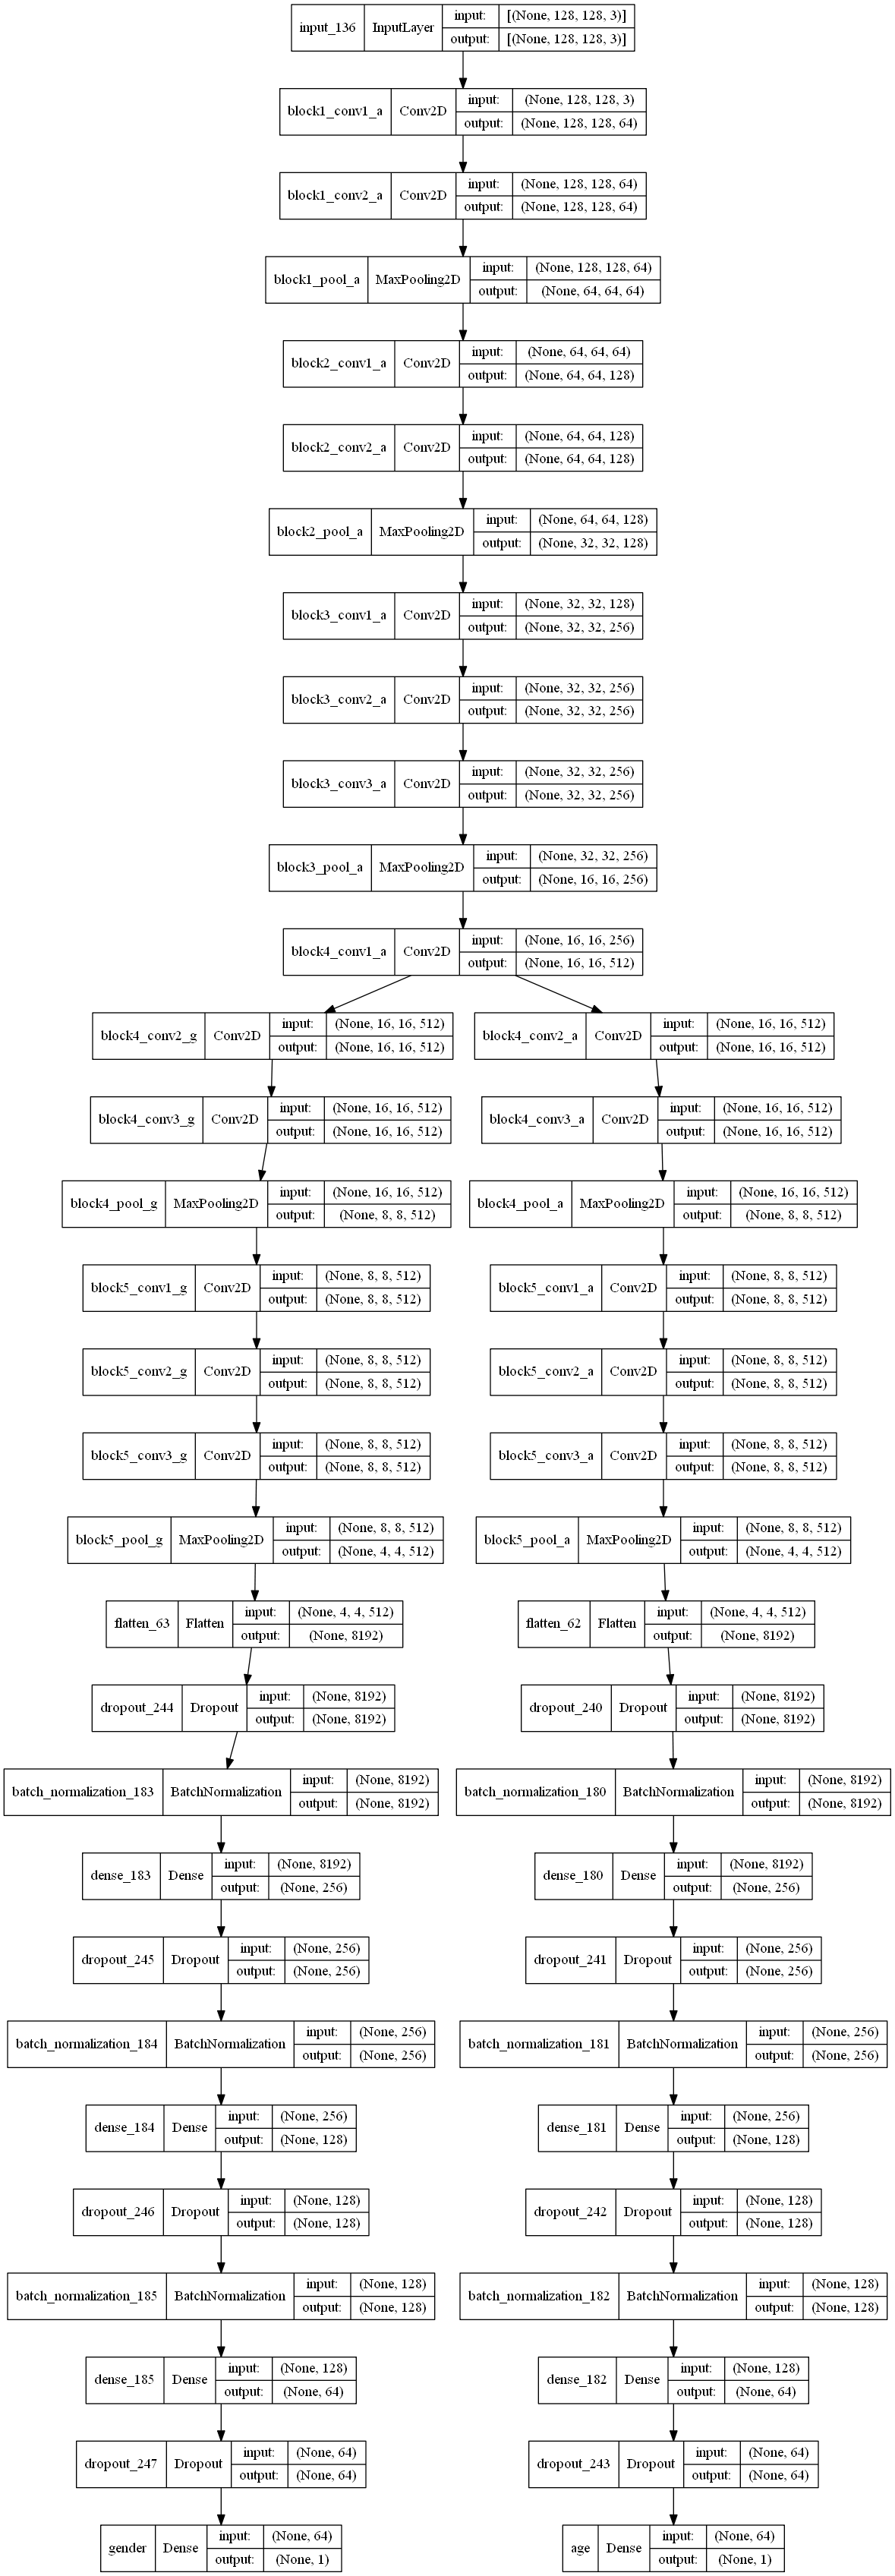

In [69]:
vgg16_a=VGG16(weights='imagenet',include_top=False, input_shape=(128,128,3))
vgg16_g=VGG16(weights='imagenet',include_top=False, input_shape=(128,128,3))
vgg16_a._name='vgg16_a'
vgg16_g._name='vgg16_g'
splitPoint=10
layers_gender,layers_age=[],[]
for i, (layer_a,layer_g) in enumerate(zip(vgg16_a.layers[1:],vgg16_g.layers[1:])):
    layer_a._name+='_a'
    layer_g._name+='_g'
    if i>=splitPoint+1:
        layer_a.trainable=False
        layer_g.trainable=False   
    # else:
#         vgg16_g.get_layer(layer_g.name).pop()
# for i in vgg16_g.layers:
#     print(i.name)
#vgg16_g.layers.pop()       
    layers_gender.append(layer_g._name)
    layers_age.append(layer_a._name)

for i in vgg16_g.layers:
    print(i.name)
vgg16_a.summary()
vgg16_g.summary()
        
def model_pre_train():
    x=Input(shape=(128,128,3))
    # for i, layer in enumerate(vgg16_a.layers[1:splitPoint]):
    #     x=layer(x)
    # #     print(layer.name)
    # #     vgg16_g.layers.pop(0)

    # a0=vgg16_a.layers[splitPoint]
    # g0=vgg16_g.get_layer(vgg16_g.layers[splitPoint].name)

    # for i, (layer_a,layer_g) in enumerate(zip(vgg16_a.layers[splitPoint+1:],vgg16_g.layers[splitPoint+1:])):
    #     #print(type(layer_a))
    #     if i == 0:
    #         a0=layer_a(a0.output)
    #         g0=vgg16_g.get_layer(layer_g.name)(g0.output)
    #     else:
    #         a0=layer_a(a0)
    #         g0=vgg16_g.get_layer(layer_g.name)(g0)
    for i, (layer,layer_g) in enumerate(zip(vgg16_a.layers[1:],vgg16_g.layers[1:])):
    # for i, layer in enumerate(vgg16_a.layers[1:]):
        print(layer.name)
        print(i)
        if i==0:
            a0=layer(x)
            print(0)
        elif i <=splitPoint:
            a0=layer(a0)
            print('1')
        elif i==splitPoint+1:
            g0=layer_g(a0)
            a0=layer(a0)
            print(2)
        else:
            a0=layer(a0)
            g0=layer_g(g0)
            print(3)

    #     print(layer.name)
    #     vgg16_g.layers.pop(0)

    a1=Flatten()(a0)

    a2 = Dropout(0.2)(a1)
    a3 = BatchNormalization()(a2)
    a4 = Dense(256,activation='relu')(a3)
    a5 = Dropout(0.2)(a4)
    a6 = BatchNormalization()(a5)
    a7 = Dense(128,activation='relu')(a6)
    a8 = Dropout(0.2)(a7)
    a9 = BatchNormalization()(a8)
    a10 = Dense(64,activation='relu')(a9)
    a11 = Dropout(0.2)(a10)
    
    age = Dense(1,activation='linear', name = 'age')(a11)
    
    g1=Flatten()(g0)

    g2 = Dropout(0.2)(g1)
    g3 = BatchNormalization()(g2)
    g4 = Dense(256,activation='relu')(g3)
    g5 = Dropout(0.2)(g4)
    g6 = BatchNormalization()(g5)
    g7 = Dense(128,activation='relu')(g6)
    g8 = Dropout(0.2)(g7)
    g9 = BatchNormalization()(g8)
    g10 = Dense(64,activation='relu')(g9)
    g11 = Dropout(0.2)(g10)

    gender = Dense(1, activation='sigmoid', name='gender')(g11)
        
    # model = Model(inputs=x, outputs =[age])

    # model.compile(loss={'age':'mse'}, optimizer=Adam(learning_rate=1e-3),
                # metrics={'age':'mae'})

    model = Model(inputs=x, outputs =[gender,age])

    model.compile(loss={'gender':'binary_crossentropy', 'age':'mse'}, optimizer=Adam(learning_rate=1e-3),
                metrics={'gender':'accuracy', 'age':'mae'})
    return model          
    
# for i, layer in enumerate(vgg16_a.layers[:4]):
#     print(i,layer.name,layer.trainable)
#     print(layer.input)
#     print(layer.output)
#     #layer.trainable=True
    # print(vgg16_g.layers[i].get_weights())

model_preTrain = model_pre_train()
model_preTrain.summary()
from tensorflow.keras.utils import plot_model
plot_model(model_preTrain, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


vgg16
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16_g (Functional)           (None, 4, 4, 512)    14714688    ['input_32[0][0]']               
                                                                                                  
 vgg16 (Functional)             (None, 4, 4, 512)    14714688    ['input_32[0][0]']               
                                                                                                  
 dropout_68 (Dropout)           (None, 4, 4, 512)    0           ['vgg16_g[0][0]']    

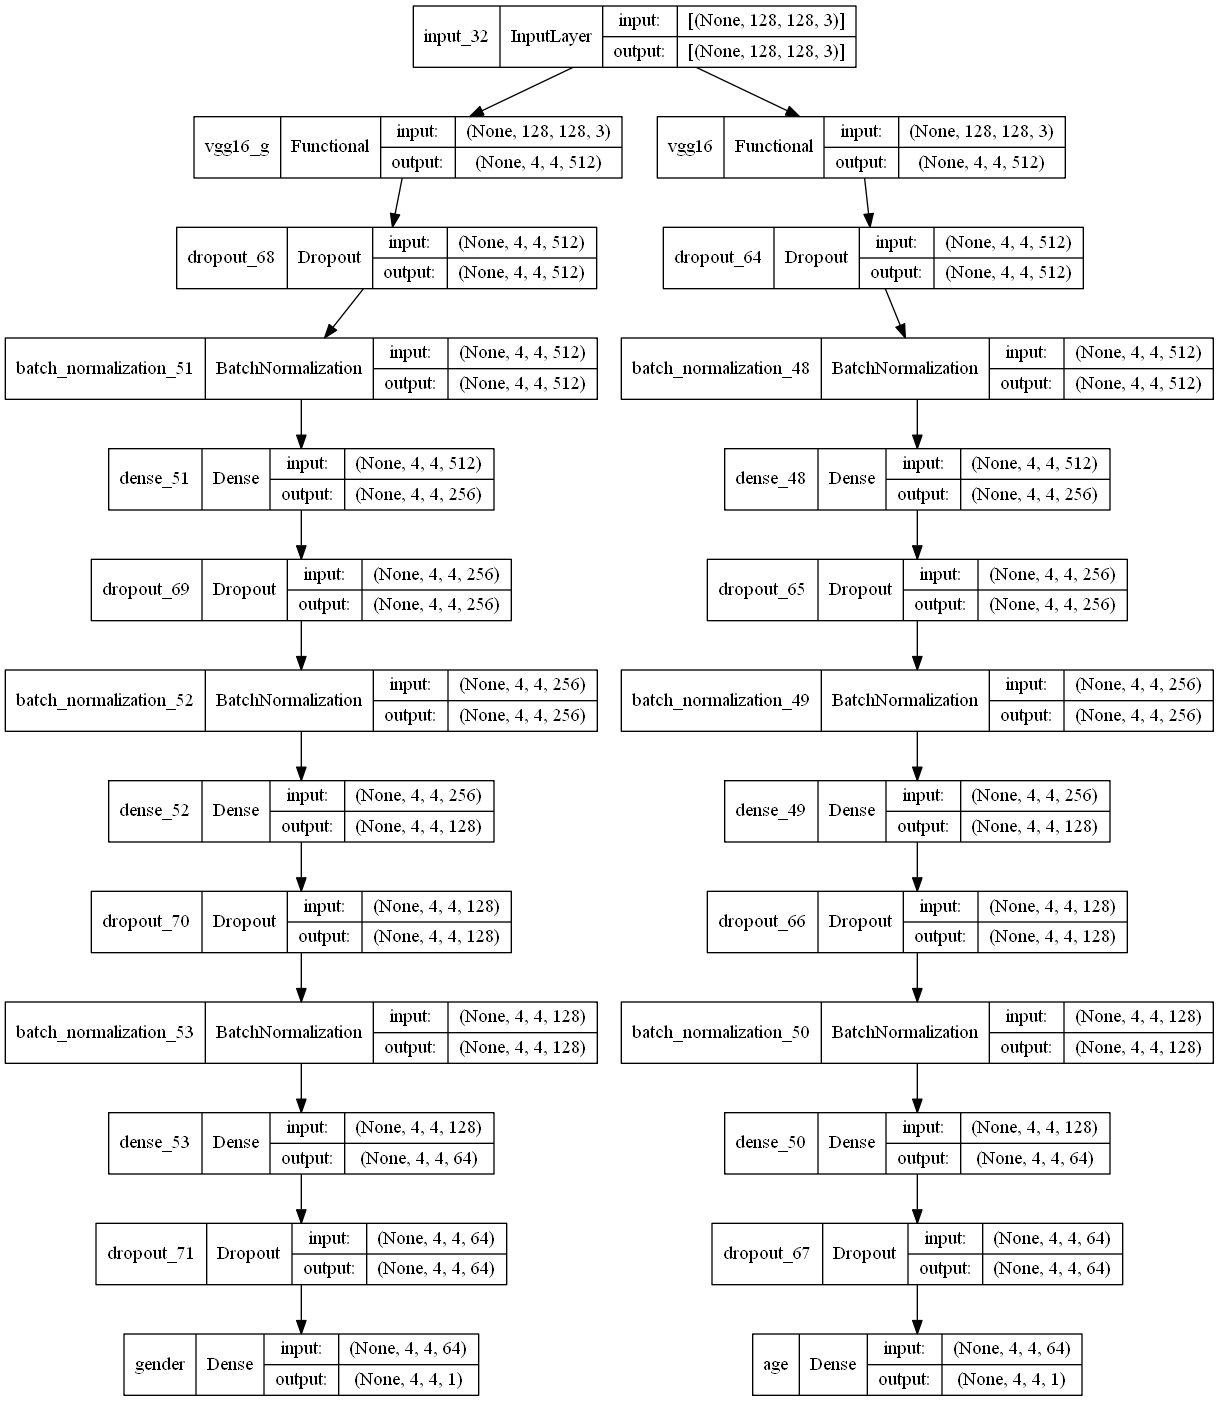

In [27]:
vgg16_a_V2=VGG16(weights='imagenet',include_top=False, input_shape=(128,128,3))

vgg16_g_V2=VGG16(weights='imagenet',include_top=False,classe=2, input_shape=(128,128,3))
print(vgg16_g_V2._name)
vgg16_g_V2._name='vgg16_g'
for i, (layer_a,layer_g) in enumerate(zip(vgg16_a.layers,vgg16_g.layers)):
    layer_a._name+='_a'
    layer_g._name+='_g'

input_layer_V2=Input(shape=(128,128,3))
a0=vgg16_a_V2(input_layer_V2)
g0=vgg16_g_V2(input_layer_V2)

a1=Flatten()(a0)
g1=Flatten()(g0)
a2 = Dropout(0.2)(a0)
a3 = BatchNormalization()(a2)
a4 = Dense(256,activation='relu')(a3)
a5 = Dropout(0.2)(a4)
a6 = BatchNormalization()(a5)
a7 = Dense(128,activation='relu')(a6)
a8 = Dropout(0.2)(a7)
a9 = BatchNormalization()(a8)
a10 = Dense(64,activation='relu')(a9)
a11 = Dropout(0.2)(a10)
    
    
g2 = Dropout(0.2)(g0)
g3 = BatchNormalization()(g2)
g4 = Dense(256,activation='relu')(g3)
g5 = Dropout(0.2)(g4)
g6 = BatchNormalization()(g5)
g7 = Dense(128,activation='relu')(g6)
g8 = Dropout(0.2)(g7)
g9 = BatchNormalization()(g8)
g10 = Dense(64,activation='relu')(g9)
g11 = Dropout(0.2)(g10)

gender = Dense(1, activation='sigmoid', name='gender')(g11)
age = Dense(1,activation='linear', name = 'age')(a11)

model = Model(inputs=input_layer_V2, outputs =[gender,age])

model.compile(loss={'gender':'binary_crossentropy', 'age':'mse'}, optimizer=Adam(learning_rate=1e-3),
                metrics={'gender':'accuracy', 'age':'mae'})

model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#
# Add your code here
#

modelB.save(your_model_folder+"age_gender_B.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#